# Support Vector Machine (SVM) Classifier

This notebook implements an SVM classifier for protein interaction prediction with cross-validation and visualization.


In [36]:
import sys
import os
sys.path.append('..')  # Add parent directory to path

from FeatureExtraction import clean_data, extract_features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, 
    precision_score,
    recall_score,
    classification_report
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from imblearn.metrics import specificity_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)


## Define Metric Functions

Following the same pattern as GradientBoosting notebook.


In [37]:
# Precision functions for each class
def prec_nonDRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def prec_DNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def prec_RNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def prec_DRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

# Recall functions for each class
def rec_nonDRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def rec_DNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def rec_RNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def rec_DRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

# Specificity functions for each class
def spe_nonDRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['nonDRNA'])[0]

def spe_DNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['DNA'])[0]

def spe_RNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['RNA'])[0]

def spe_DRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['DRNA'])[0]



## Load and Prepare Data


In [38]:
# Load raw sequences
data = pd.read_csv('../sequences_training.txt', header=None)
data.columns = ['protien_seq', 'class']

# Clean ambiguous amino acids (remove them)
data = clean_data(data, substitute=False)

# Extract rich BioPython features
data = extract_features(data)


## Prepare Features and Labels


In [39]:
# Separate features and labels (scaling handled by pipeline)
X = data.drop('class', axis=1)
y = data['class']


## Create Pipeline with Preprocessor and Classifier


In [40]:
# Create pipeline with preprocessor and classifier
# Option 1: Simple pipeline (fastest - same speed as before)
# svm_pipeline = Pipeline([
#     ('preprocessor', StandardScaler()),  # Can also try MinMaxScaler() or QuantileTransformer()
#     ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True))
# ])

# Option 2: With sampling for better class imbalance handling (20-50% slower)
# Uncomment to use - helps with DRNA class (only 22 samples)
svm_pipeline = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),  # or SMOTE(random_state=42)
    ('preprocessor', StandardScaler()),
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True))
])


## 5-Fold Cross-Validation


In [41]:
# Cross-validation with pipeline
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(svm_pipeline, X, y, cv=skf)


## Calculate Metrics (Precision, Recall, Specificity)


In [42]:
# Calculate metrics for each class
classes = ['DNA', 'RNA', 'DRNA', 'nonDRNA']

# Map class names to function names
prec_funcs = {'DNA': prec_DNA, 'RNA': prec_RNA, 'DRNA': prec_DRNA, 'nonDRNA': prec_nonDRNA}
rec_funcs = {'DNA': rec_DNA, 'RNA': rec_RNA, 'DRNA': rec_DRNA, 'nonDRNA': rec_nonDRNA}
spe_funcs = {'DNA': spe_DNA, 'RNA': spe_RNA, 'DRNA': spe_DRNA, 'nonDRNA': spe_nonDRNA}

metrics = {}
for cls in classes:
    metrics[cls] = {
        'Precision': prec_funcs[cls](y, y_pred)[0],
        'Recall': rec_funcs[cls](y, y_pred)[0],
        'Specificity': spe_funcs[cls](y, y_pred)
    }

# Create results DataFrame
results_df = pd.DataFrame(metrics).T
results_df.index.name = 'Class'



## Visualizations


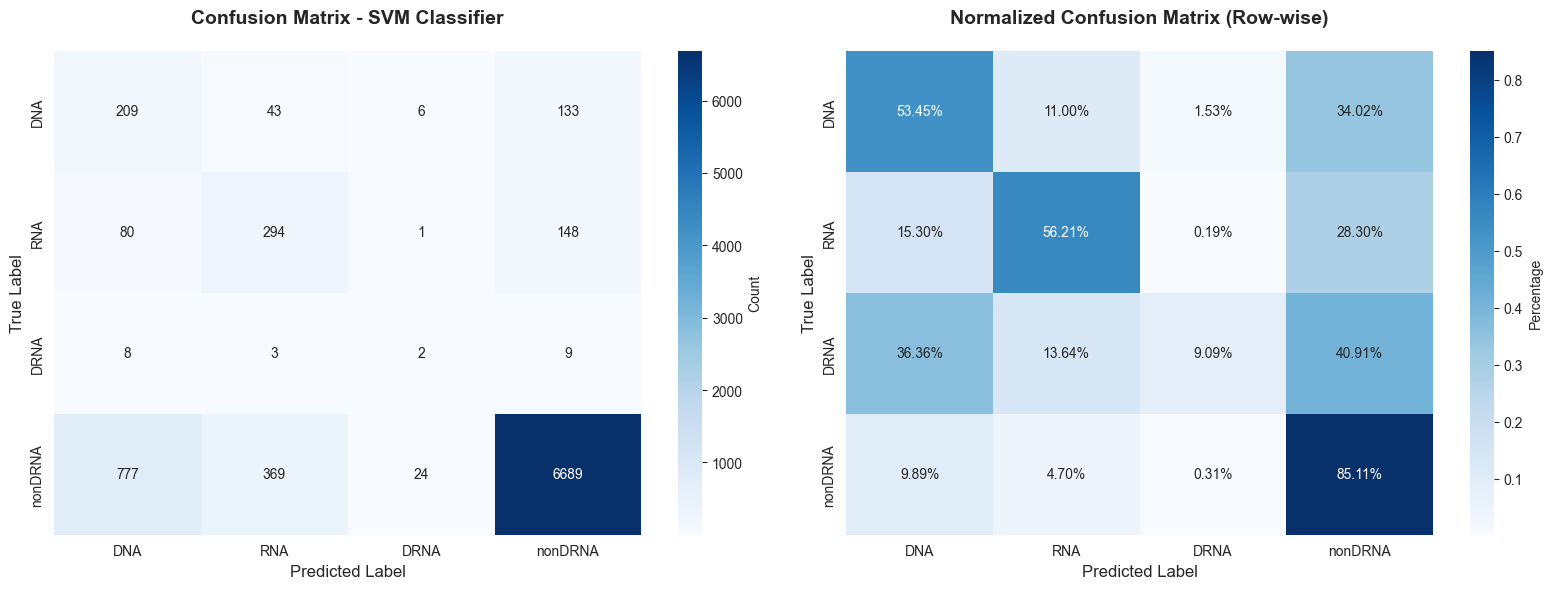

In [43]:
# Confusion Matrix
cm = confusion_matrix(y, y_pred, labels=classes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=ax1)
ax1.set_title('Confusion Matrix - SVM Classifier', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'}, ax=ax2)
ax2.set_title('Normalized Confusion Matrix (Row-wise)', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()


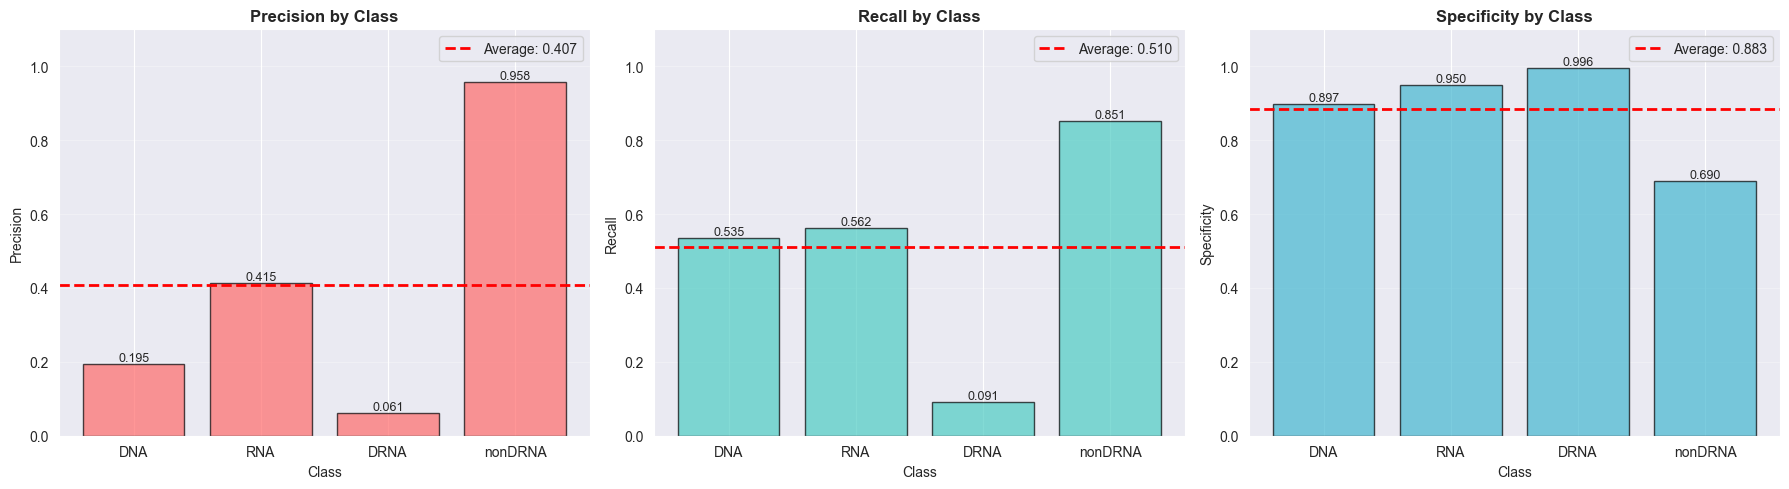

In [44]:
# Metrics comparison by class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['Precision', 'Recall', 'Specificity']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx]
    bars = ax.bar(classes, results_df[metric], color=color, edgecolor='black', alpha=0.7)
    ax.set_title(f'{metric} by Class', fontsize=12, fontweight='bold')
    ax.set_xlabel('Class', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_ylim([0, 1.1])
    ax.axhline(y=results_df[metric].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Average: {results_df[metric].mean():.3f}')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, cls in zip(bars, classes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


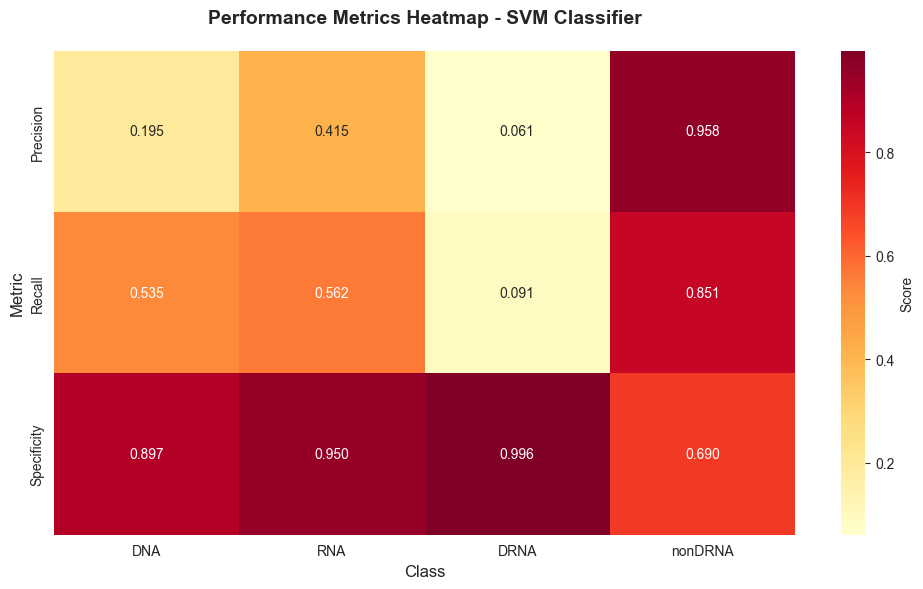

In [45]:
# Heatmap of all metrics
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(results_df.T, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score'}, ax=ax)
ax.set_title('Performance Metrics Heatmap - SVM Classifier', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Metric', fontsize=12)
plt.tight_layout()
plt.show()


In [46]:
# Classification report
print("\nDetailed Classification Report:")
print("="*80)
print(classification_report(y, y_pred, target_names=classes, digits=4))
print("="*80)



Detailed Classification Report:
              precision    recall  f1-score   support

         DNA     0.1946    0.5345    0.2853       391
         RNA     0.0606    0.0909    0.0727        22
        DRNA     0.4147    0.5621    0.4773       523
     nonDRNA     0.9584    0.8511    0.9016      7859

    accuracy                         0.8180      8795
   macro avg     0.4071    0.5097    0.4342      8795
weighted avg     0.8899    0.8180    0.8469      8795



## Summary

- **Model**: Support Vector Machine (SVM) with RBF kernel
- **Pipeline**: Preprocessor + Classifier (using imblearn Pipeline)
- **Cross-Validation**: 5-fold stratified
- **Metrics**: Precision, Recall, Specificity (per class)

### Notes:
- Pipeline structure makes cross-validation more efficient
- Option 1 (default): Fast - same speed as before, no sampling
- Option 2 (commented): Slower but better for class imbalance - uncomment to use sampling
- Can try different preprocessors: StandardScaler, MinMaxScaler, QuantileTransformer
- For better DRNA prediction, consider enabling Option 2 (sampling)
